In [1]:
%load_ext autoreload

%autoreload 2
from astropy.io import fits as fits
import matplotlib.pyplot as plt
import pickle
import sys
import emcee
import numpy as np
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
from astropy.table import Table, QTable, hstack, vstack
from astropy import units as u
import corner
cosmo_astropy = FlatLambdaCDM(H0=71.0, Om0=0.265, Ob0 = 0.0448)
import iminuit
from iminuit import Minuit
cosmo_astropy.critical_density(0.4).to(u.Msun / u.Mpc**3).value

sys.path.append('../../modeling')
import CL_COUNT_modeling_completeness as comp
import CL_COUNT_modeling_purity as pur
import CL_COUNT_modeling_halo_mass_function as hmf
import CL_COUNT_modeling_richness_mass_relation as rm_relation
import CL_MASS_cluster_mass as cl_mass
import CL_COUNT_cluster_abundance as cl_count
import CL_COUNT_class_likelihood as likelihood
import CL_LENSING_cluster_lensing as cl_lensing

/pbs/home/c/cpayerne/.conda/envs/myenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
name = '../../../CLCosmo_Sim_database/data/matched_pairs_Mfofcut.fits'
dat = fits.open(name)
dat_open= dat[1].data

In [3]:
dat_open['cat1_id']

chararray(['10', '18', '24', ..., '97912', '37112', '74968'], dtype='<U11')

In [4]:
table = Table()
table['richness'] = dat_open['cat1_richness']
table['M200c'] = dat_open['cat2_M200c']
table['redshift'] = dat_open['cat1_ztrue_cg']

In [5]:
richness_min = 10
table_cut = table[(table['M200c'] > 4e13)*(table['richness'] > richness_min)*(table['redshift'] < 1)*(table['redshift'] > .2)]
#table_cut2 = table[(table['M200c'] < 2e14)*(table['M200c'] > 2e13)*(table['richness'] > 20)*(table['redshift'] < 1)*(table['redshift'] > .2)]

In [6]:
import scipy
u = np.linspace(-50, 50, 2000)
pu = 0.5*(1 + scipy.special.erf(u))
def p_f(x):
    return np.interp(x, u, pu, left=None, right=None)

In [7]:
def lnLikelihood(p, table_cut):
    proxy_mu0, proxy_muz, proxy_mulog10m, proxy_sigma0, proxy_sigmaz, proxy_sigmalog10m = p
    params = np.log10(10**14.3), .5, proxy_mu0, proxy_muz, proxy_mulog10m, proxy_sigma0, proxy_sigmaz, proxy_sigmalog10m 
    mu = rm_relation.proxy_mu_f(np.log10(table_cut['M200c']), table_cut['redshift'],  params)
    sigma= rm_relation.proxy_sigma_f(np.log10(table_cut['M200c']), table_cut['redshift'],  params)
    pdf_lnlambda = table_cut['richness']*rm_relation.pdf_richness_mass_relation(table_cut['richness'], np.log10(table_cut['M200c']), table_cut['redshift'], params)
    normalx = np.array((np.log(richness_min) - mu)/(np.sqrt(2)*sigma))
    normalp =  p_f(normalx)
    pdf_lnlambda = pdf_lnlambda/(1-normalp)
    if np.isnan(np.sum(np.log(pdf_lnlambda))): return -np.inf
    return np.sum(np.log(pdf_lnlambda))

In [8]:
initial = [3.33413625, -0.01682437,  2.34084305,  0.56353637, -0.10364501,  0.00758468,]
lnLikelihood(initial, table_cut)

-2708.7772096678714

In [9]:
def params(table_cut):
    from multiprocessing import Pool
    nwalker=20
    pos=.001*np.random.randn(nwalker,6) + initial
    with Pool() as pool:
        sampler = emcee.EnsembleSampler(nwalker, 6, lnLikelihood, pool=pool,args=[table_cut])
        sampler.run_mcmc(pos, 400, progress=True);
    flat_samples = sampler.get_chain(discard=10, thin=3, flat=True)
    p = np.mean(flat_samples[2000:], axis=0)
    p_err = np.std(flat_samples[2000:], axis=0)
    params = [np.log10(10**14.3), .5]
    params_err = [0,0]
    params = params + list(p)
    params_err = params_err + list(p_err)
    return params, params_err

In [10]:
#plt.plot(flat_samples2[:,2])
#print(np.mean(flat_samples2[2000:], axis=0))
#np.save('fiducial.pkl',flat_samples1[2000:],)

In [11]:
#plt.plot(flat_samples2[:,2])
#print(np.mean(flat_samples2[2000:], axis=0))
#np.save('fiducial.pkl',flat_samples1[2000:],)

In [12]:
#p = np.mean(flat_samples2[2000:], axis=0)
#params = [np.log10(10**14.3), .5]
#params = params + list(p)

In [13]:
params1, params1_err = params(table_cut)

100%|██████████| 400/400 [00:07<00:00, 54.34it/s]


In [14]:
for i in range(8):
    print(f'{params1[i]:.2f} $\pm$ {params1_err[i]:.2f}')

14.30 $\pm$ 0.00
0.50 $\pm$ 0.00
3.35 $\pm$ 0.01
0.09 $\pm$ 0.08
2.22 $\pm$ 0.05
0.56 $\pm$ 0.01
-0.04 $\pm$ 0.04
0.10 $\pm$ 0.02


In [15]:
params1

[14.3,
 0.5,
 3.3461621701187343,
 0.08729081993287556,
 2.223102235019151,
 0.5625394111447514,
 -0.043959440595343374,
 0.10261718639136165]

In [16]:
#params2 = params(table_cut2)

In [17]:
np.log(richness_min)

2.302585092994046

In [18]:
# plt.figure(figsize=(10,3))
# plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=., hspace=None)
# plt.subplot(122)
# plt.xlabel(r'redMaPPer log($\lambda$)', fontsize=12)
# plt.tick_params(axis='both', which = 'major', labelsize= 12)
# plt.ylabel(r'PDF/histogram', fontsize=12)
# plt.grid(True, which="both")
# bin_lambda = np.linspace(np.log(richness_min), 20, 150)
# bin_lambda_mid = [(bin_lambda[i]+bin_lambda[i+1])/2 for i in range(len(bin_lambda)-1)]
# color = ['C'+str(i) for i in range(20)]
# richness = np.linspace(richness_min, 1000, 1000)

# log_mass_bins = [[14,  14.1], [14.3,  14.4], [14.4,  14.6]]
# for i, log_mass_bin in enumerate(log_mass_bins):
#     mean_log_mass = np.mean(log_mass_bin)
#     mean_z = (1 + 0.2)/2
#     mask_z_1 = (table_cut['redshift'] > 0.2)*(table_cut['redshift'] < 1)
    
#     #model
#     mu = rm_relation.proxy_mu_f(mean_log_mass, mean_z,   params1)
#     sigma = rm_relation.proxy_sigma_f(mean_log_mass, mean_z,params1)
#     pdf_lnlambda = richness*rm_relation.pdf_richness_mass_relation(richness, mean_log_mass, mean_z, params1)
#     normalx = np.array((np.log(richness_min) - mu)/(np.sqrt(2)*sigma))
#     normalp =  p_f(normalx)
#     pdf_lnlambda = pdf_lnlambda/(1-normalp)
#     plt.plot(np.log(richness), pdf_lnlambda/np.trapz(pdf_lnlambda, np.log(richness)), color=color[i])

#     mask = (table_cut['M200c'] > 10**log_mass_bin[0]) * (table_cut['M200c'] < 10**log_mass_bin[1]) * mask_z_1
#     n, b, p=plt.hist(np.log(table_cut['richness'][mask]), 
#      histtype='step', lw=2, label = r'$\log_{10}M$'+f'$\in$ [{log_mass_bin[0]:.1f}, {log_mass_bin[1]:.1f}]', bins=bin_lambda,
#             color = color[i], density=True)

# plt.legend(fontsize=9)
# #plt.yscale('log')
# plt.xlim(np.log(richness_min), 6)
    
# plt.subplot(121)
# plt.tick_params(axis='both', which = 'major', labelsize= 12)
# plt.scatter( table['M200c'], table['richness'],
#             c=table['redshift'], s=7, cmap='jet')
# m = np.linspace(0.11e13, 3e15, 10)
# mu = rm_relation.proxy_mu_f(np.log10(m) , .4,  params1,)
# sigma = rm_relation.proxy_sigma_f(np.log10(m) , .4,  params1,)
# plt.plot(m, np.exp(mu) , color='darkblue',lw=1, label = 'best fit at z=0.4')
# #plt.fill_between(m,mu+ sigma,mu-sigma,  alpha=.3)


# plt.colorbar().set_label(label=r'redshift',size=12,)
# plt.xlim(5e12, 3e15)
# plt.ylim(3)
# plt.yscale('log')
# plt.legend()
# plt.grid(which='both')
# plt.xscale('log')
# plt.vlines(4e13, -100, 1000, color = 'k',ls='--')
# plt.hlines(richness_min, -1000, 1e16, color = 'k',ls='--')
# plt.ylabel(r'redMaPPer $\lambda$', fontsize=12)
# plt.xlabel(r'cosmoDC2 $M_{\rm 200c}\ [M_\odot]$', fontsize=12)
# #plt.savefig('../fig/fiducial_relation.pdf', bbox_inches='tight', dpi=300)

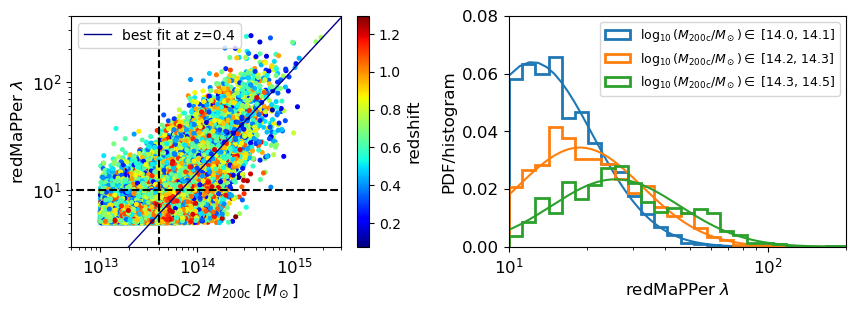

In [20]:
plt.figure(figsize=(10,3))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.3, hspace=None)
plt.subplot(122)
plt.xlabel(r'redMaPPer $\lambda$', fontsize=12)
plt.tick_params(axis='both', which = 'major', labelsize= 12)
plt.ylabel(r'PDF/histogram', fontsize=12)
#plt.grid(True, which="both")
color = ['C'+str(i) for i in range(20)]
richness = np.linspace(richness_min, 1000, 1000)

log_mass_bins = [[14,  14.1], [14.2,  14.3], [14.3,  14.5]]
for i, log_mass_bin in enumerate(log_mass_bins):
    mean_log_mass = np.mean(log_mass_bin)
    mean_z = (1 + 0.2)/2
    mask_z_1 = (table_cut['redshift'] > 0.2)*(table_cut['redshift'] < 1)
    
    #model
    mu = rm_relation.proxy_mu_f(mean_log_mass, mean_z,   params1)
    sigma = rm_relation.proxy_sigma_f(mean_log_mass, mean_z,params1)
    pdf_lnlambda = richness*rm_relation.pdf_richness_mass_relation(richness, mean_log_mass, mean_z, params1)
    normalx = np.array((np.log(richness_min) - mu)/(np.sqrt(2)*sigma))
    normalp =  p_f(normalx)
    pdf_lnlambda = pdf_lnlambda/(1-normalp)
    plt.plot(richness, pdf_lnlambda/(richness*np.trapz(pdf_lnlambda, np.log(richness))), color=color[i])

    mask = (table_cut['M200c'] > 10**log_mass_bin[0]) * (table_cut['M200c'] < 10**log_mass_bin[1]) * mask_z_1
    bin_lambda = np.logspace(np.log10(10), np.log10(300), 30)
    bin_lambda_mid = [(bin_lambda[i]+bin_lambda[i+1])/2 for i in range(len(bin_lambda)-1)]
    n, b, p=plt.hist(table_cut['richness'][mask], 
     histtype='step', lw=2, label = r'$\log_{10}(M_{\rm 200c}/M_\odot)$'+f'$\in$ [{log_mass_bin[0]:.1f}, {log_mass_bin[1]:.1f}]', 
                     bins=bin_lambda,
            color = color[i], density=True)

plt.legend(fontsize=9)
plt.ylim(0, 0.08)
plt.xscale('log')
plt.xlim(richness_min, 200)
    
plt.subplot(121)
plt.tick_params(axis='both', which = 'major', labelsize= 12)
plt.scatter( table['M200c'], table['richness'],
            c=table['redshift'], s=7, cmap='jet')
m = np.linspace(0.11e13, 3e15, 10)
mu = rm_relation.proxy_mu_f(np.log10(m) , .4,  params1,)
sigma = rm_relation.proxy_sigma_f(np.log10(m) , .4,  params1,)
plt.plot(m, np.exp(mu) , color='darkblue',lw=1, label = 'best fit at z=0.4')
#plt.fill_between(m,mu+ sigma,mu-sigma,  alpha=.3)


plt.colorbar().set_label(label=r'redshift',size=12,)
plt.xlim(5e12, 3e15)
plt.ylim(3)
plt.yscale('log')
plt.legend()
#plt.grid(which='both')
plt.xscale('log')
plt.vlines(4e13, -100, 1000, color = 'k',ls='--')
plt.hlines(richness_min, -1000, 1e16, color = 'k',ls='--')
plt.ylabel(r'redMaPPer $\lambda$', fontsize=12)
plt.xlabel(r'cosmoDC2 $M_{\rm 200c}\ [M_\odot]$', fontsize=12)
plt.savefig('../fig/fiducial_relation.pdf', bbox_inches='tight', dpi=300)